In [1]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from tqdm import tqdm_notebook
import csv
import pandas as pd
import matchzoo as mz
import math

c:\users\yusuf\appdata\local\programs\python\python37\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
Using TensorFlow backend.
c:\users\yusuf\appdata\local\programs\python\python37\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
data = []
with open('data/data-part-01.txt', newline = '') as aol_data:                                                                                          
    data = csv.reader(aol_data, delimiter='\t')
    data = list(data)
    
df = pd.DataFrame.from_records(data[1:], columns=data[0])
df['ItemRank'] = pd.to_numeric(df['ItemRank'], errors='ignore')
# queries = df['Query'].tolist()
del data

In [3]:
df = df.sample(10000, random_state=23)

for index, row in tqdm_notebook(df.iterrows()):
    if row['ItemRank'] >= 0:
        df.loc[index, 'Clicked'] = 1
    else:
        df.loc[index, 'Clicked'] = 0


In [4]:
queries = df['Query'].tolist()
clicked = df['Clicked'].tolist()

In [5]:
prefixes = []
suffixes = []
pairs = []
labels = []

for i in range(5000):
    words = queries[i].split()
    for j in range(1, len(words)):
        prefix = " ".join(words[:j])
        suffix = " ".join(words[j:])
        prefixes.append(prefix)
        suffixes.append(suffix)
        pairs.append([prefix, suffix])
        labels.append(clicked[i])

del queries
del clicked

In [6]:
def split(original_list, weight_list):
    sublists = []
    prev_index = 0
    for weight in weight_list:
        next_index = prev_index + math.ceil( (len(original_list) * weight) )

        sublists.append( original_list[prev_index : next_index] )
        prev_index = next_index

    return sublists

tr_prefix, val_prefix, test_prefix = split(prefixes, [0.7, 0.2, 0.1])
tr_suffix, val_suffix, test_suffix = split(suffixes, [0.7, 0.2, 0.1])
tr_labels, val_labels, test_labels = split(labels, [0.7, 0.2, 0.1])

In [7]:
train_data = pd.DataFrame({
    'text_left': tr_prefix,
    'text_right': tr_suffix,
    'label': tr_labels
})

val_data = pd.DataFrame({
    'text_left': val_prefix,
    'text_right': val_suffix,
    'label': val_labels
})

test_data = pd.DataFrame({
    'text_left': test_prefix,
    'text_right': test_suffix,
    'label': test_labels
})

train_pack = mz.pack(train_data)
val_pack = mz.pack(val_data)
test_pack = mz.pack(test_data)
test_pack.frame()

,id_left,text_left,id_right,text_right,label
0,L-0,social,R-0,work malpractice insurance,0.0
1,L-1,social work,R-1,malpractice insurance,0.0
2,L-2,social work malpractice,R-2,insurance,0.0
3,L-3,northern,R-3,tool,0.0
4,L-4,colt,R-4,government 380 handgun grips,1.0
...,...,...,...,...,...
731,L-706,vintage ornateserving fork brass nude,R-705,female and cherub bordini italy,0.0
732,L-707,vintage ornateserving fork brass nude female,R-706,and cherub bordini italy,0.0
733,L-708,vintage ornateserving fork brass nude female and,R-707,cherub bordini italy,0.0
734,L-709,vintage ornateserving fork brass nude female a...,R-708,bordini italy,0.0


In [8]:
preprocessor = mz.preprocessors.CDSSMPreprocessor(fixed_length_left=10, fixed_length_right=10)
train_pack_processed = preprocessor.fit_transform(train_pack)
valid_pack_processed = preprocessor.transform(val_pack)
test_pack_processed = preprocessor.transform(test_pack)

ranking_task = mz.tasks.Ranking(loss=mz.losses.RankHingeLoss())
ranking_task.metrics = [
    mz.metrics.NormalizedDiscountedCumulativeGain(k=3),
    mz.metrics.NormalizedDiscountedCumulativeGain(k=5),
    mz.metrics.MeanAveragePrecision()
]

Processing text_left with chain_transform of Tokenize => Lowercase => PuncRemoval => StopRemoval => NgramLetter: 100%|██████████| 4518/4518 [00:00<00:00, 12859.79it/s]
Processing text_right with chain_transform of Tokenize => Lowercase => PuncRemoval => StopRemoval => NgramLetter: 100%|██████████| 4487/4487 [00:00<00:00, 12956.09it/s]
Building Vocabulary from a datapack.: 100%|██████████| 105362/105362 [00:00<00:00, 3508863.13it/s]
Processing text_left with chain_transform of Tokenize => Lowercase => PuncRemoval => StopRemoval: 100%|██████████| 4518/4518 [00:00<00:00, 14105.92it/s]
Processing text_right with chain_transform of Tokenize => Lowercase => PuncRemoval => StopRemoval: 100%|██████████| 4487/4487 [00:00<00:00, 14186.47it/s]
Processing text_right with transform: 100%|██████████| 4487/4487 [00:00<00:00, 149433.80it/s]
Processing text_left with chain_transform of NgramLetter => WordHashing: 100%|██████████| 4518/4518 [00:04<00:00, 954.92it/s] 
Processing text_right with chain_tra

In [9]:
model = mz.models.CDSSM()
model.params['input_shapes'] = preprocessor.context['input_shapes']
model.params['task'] = ranking_task
model.params['filters'] = 64
model.params['kernel_size'] = 3
model.params['strides'] = 1
model.params['padding'] = 'same'
model.params['conv_activation_func'] = 'tanh'
model.params['w_initializer'] = 'glorot_normal'
model.params['b_initializer'] = 'zeros'
model.params['mlp_num_layers'] = 1
model.params['mlp_num_units'] = 64
model.params['mlp_num_fan_out'] = 64
model.params['mlp_activation_func'] = 'tanh'
model.params['dropout_rate'] = 0.8
model.params['optimizer'] = 'adadelta'
model.guess_and_fill_missing_params()
model.build()
model.compile()
model.backend.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_left (InputLayer)          (None, 10, 4367)     0                                            
__________________________________________________________________________________________________
text_right (InputLayer)         (None, 10, 4367)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 10, 64)       838528      text_left[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 10, 64)       838528      text_right[0][0]                 
____________________________________________________________________________________________

In [10]:
pred_x, pred_y = test_pack_processed[:].unpack()
evaluate = mz.callbacks.EvaluateAllMetrics(model, x=pred_x, y=pred_y, batch_size=len(pred_x))
train_generator = mz.DataGenerator(
    train_pack_processed,
    mode='pair',
    num_dup=2,
    num_neg=1,
    batch_size=20
)
print('num batches:', len(train_generator))

num batches: 35


In [11]:
history = model.fit_generator(train_generator, epochs=20, callbacks=[evaluate], workers=2, use_multiprocessing=False)

Epoch 1/20
 1/35 [..............................] - ETA: 30s - loss: 1.0107

c:\users\yusuf\appdata\local\programs\python\python37\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.878800). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 2/35 [>.............................] - ETA: 31s - loss: 1.0223

c:\users\yusuf\appdata\local\programs\python\python37\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.440401). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


35/35 [==============================] - ETA: 22s - loss: 1.02 - ETA: 17s - loss: 1.01 - ETA: 14s - loss: 1.00 - ETA: 12s - loss: 1.00 - ETA: 10s - loss: 1.00 - ETA: 9s - loss: 1.0003 - ETA: 8s - loss: 0.996 - ETA: 7s - loss: 0.995 - ETA: 7s - loss: 0.994 - ETA: 6s - loss: 0.989 - ETA: 6s - loss: 0.991 - ETA: 5s - loss: 0.989 - ETA: 5s - loss: 0.986 - ETA: 5s - loss: 0.982 - ETA: 4s - loss: 0.983 - ETA: 4s - loss: 0.981 - ETA: 3s - loss: 0.978 - ETA: 3s - loss: 0.976 - ETA: 3s - loss: 0.967 - ETA: 3s - loss: 0.964 - ETA: 2s - loss: 0.963 - ETA: 2s - loss: 0.956 - ETA: 2s - loss: 0.951 - ETA: 1s - loss: 0.948 - ETA: 1s - loss: 0.944 - ETA: 1s - loss: 0.945 - ETA: 1s - loss: 0.944 - ETA: 0s - loss: 0.941 - ETA: 0s - loss: 0.935 - ETA: 0s - loss: 0.935 - ETA: 0s - loss: 0.929 - ETA: 0s - loss: 0.924 - 6s 180ms/step - loss: 0.9221
Validation: normalized_discounted_cumulative_gain@3(0.0): 0.6180904029062325 - normalized_discounted_cumulative_gain@5(0.0): 0.618673133586234 - mean_average_pre

35/35 [==============================] - ETA: 4s - loss: 0.215 - ETA: 5s - loss: 0.271 - ETA: 4s - loss: 0.223 - ETA: 4s - loss: 0.186 - ETA: 4s - loss: 0.177 - ETA: 4s - loss: 0.189 - ETA: 4s - loss: 0.199 - ETA: 4s - loss: 0.196 - ETA: 3s - loss: 0.193 - ETA: 3s - loss: 0.185 - ETA: 3s - loss: 0.173 - ETA: 3s - loss: 0.174 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.171 - ETA: 3s - loss: 0.164 - ETA: 2s - loss: 0.158 - ETA: 2s - loss: 0.151 - ETA: 2s - loss: 0.148 - ETA: 2s - loss: 0.147 - ETA: 2s - loss: 0.150 - ETA: 2s - loss: 0.156 - ETA: 2s - loss: 0.156 - ETA: 1s - loss: 0.162 - ETA: 1s - loss: 0.163 - ETA: 1s - loss: 0.157 - ETA: 1s - loss: 0.153 - ETA: 1s - loss: 0.149 - ETA: 1s - loss: 0.148 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.147 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.145 - ETA: 0s - loss: 0.148 - ETA: 0s - loss: 0.148 - 5s 131ms/step - loss: 0.1475
Validation: normalized_discounted_cumulative_gain@3(0.0): 0.6194423495565282 - normalized_discounted_cumulative_ga

35/35 [==============================] - ETA: 7s - loss: 0.033 - ETA: 6s - loss: 0.042 - ETA: 6s - loss: 0.049 - ETA: 5s - loss: 0.044 - ETA: 5s - loss: 0.036 - ETA: 4s - loss: 0.030 - ETA: 4s - loss: 0.046 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.055 - ETA: 4s - loss: 0.061 - ETA: 4s - loss: 0.067 - ETA: 3s - loss: 0.063 - ETA: 3s - loss: 0.062 - ETA: 3s - loss: 0.072 - ETA: 3s - loss: 0.068 - ETA: 3s - loss: 0.075 - ETA: 2s - loss: 0.073 - ETA: 2s - loss: 0.074 - ETA: 2s - loss: 0.085 - ETA: 2s - loss: 0.087 - ETA: 2s - loss: 0.084 - ETA: 2s - loss: 0.090 - ETA: 1s - loss: 0.088 - ETA: 1s - loss: 0.086 - ETA: 1s - loss: 0.083 - ETA: 1s - loss: 0.087 - ETA: 1s - loss: 0.085 - ETA: 1s - loss: 0.086 - ETA: 0s - loss: 0.087 - ETA: 0s - loss: 0.085 - ETA: 0s - loss: 0.087 - ETA: 0s - loss: 0.086 - ETA: 0s - loss: 0.084 - ETA: 0s - loss: 0.082 - 5s 138ms/step - loss: 0.0808
Validation: normalized_discounted_cumulative_gain@3(0.0): 0.6194423495565282 - normalized_discounted_cumulative_ga

KeyError: 'mean_average_precision'

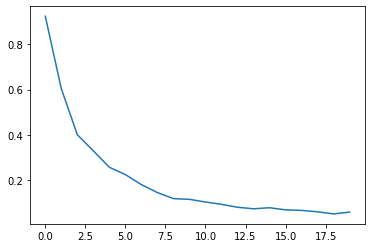

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['mean_average_precision'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
